# Building deep retrieval models

**Learning Objectives**

1. Converting raw input examples into feature embeddings.
2. Splitting the data into a training set and a testing set.
3. Configuring the deeper model with losses and metrics.





## Introduction 
In [the featurization tutorial](https://www.tensorflow.org/recommenders/examples/featurization) we incorporated multiple features into our models, but the models consist of only an embedding layer. We can add more dense layers to our models to increase their expressive power.

In general, deeper models are capable of learning more complex patterns than shallower models. For example, our [user model](fhttps://www.tensorflow.org/recommenders/examples/featurization#user_model) incorporates user ids and timestamps to model user preferences at a point in time. A shallow model (say, a single embedding layer) may only be able to learn the simplest relationships between those features and movies: a given movie is most popular around the time of its release, and a given user generally prefers horror movies to comedies. To capture more complex relationships, such as user preferences evolving over time, we may need a deeper model with multiple stacked dense layers.

Of course, complex models also have their disadvantages. The first is computational cost, as larger models require both more memory and more computation to fit and serve. The second is the requirement for more data: in general, more training data is needed to take advantage of deeper models. With more parameters, deep models might overfit or even simply memorize the training examples instead of learning a function that can generalize. Finally, training deeper models may be harder, and more care needs to be taken in choosing settings like regularization and learning rate.

Finding a good architecture for a real-world recommender system is a complex art, requiring good intuition and careful [hyperparameter tuning](https://en.wikipedia.org/wiki/Hyperparameter_optimization). For example, factors such as the depth and width of the model, activation function, learning rate, and optimizer can radically change the performance of the model. Modelling choices are further complicated by the fact that good offline evaluation metrics may not correspond to good online performance, and that the choice of what to optimize for is often more critical than the choice of model itself.


Each learning objective will correspond to a __#TODO__ in the [student lab notebook](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/recommendation_systems/labs/deep_recommenders.ipynb) -- try to complete that notebook first before reviewing this solution notebook.

## Preliminaries

We first import the necessary packages.

In [2]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

**NOTE: Please ignore any incompatibility warnings and errors and re-run the above cell before proceeding.**


In [3]:
import os
import tempfile

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import tensorflow_recommenders as tfrs

plt.style.use('seaborn-whitegrid')

This notebook uses TF2.x.
Please check your tensorflow version using the cell below.

In [ ]:
# Show the currently installed version of TensorFlow
print("TensorFlow version: ",tf.version.VERSION)

TensorFlow version:  2.3.0


In this tutorial we will use the models from [the featurization tutorial](https://www.tensorflow.org/recommenders/examples/featurization) to generate embeddings. Hence we will only be using the user id, timestamp, and movie title features.

In [4]:
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")

ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "timestamp": x["timestamp"],
})
movies = movies.map(lambda x: x["movie_title"])

Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/movielens/100k-ratings/0.1.0.incompleteFP7002/movielens-train.tfrecord


Dataset movielens downloaded and prepared to /home/kbuilder/tensorflow_datasets/movielens/100k-ratings/0.1.0. Subsequent calls will reuse this data.


Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/movielens/100k-movies/0.1.0.incomplete4D5YLJ/movielens-train.tfrecord
Dataset movielens downloaded and prepared to /home/kbuilder/tensorflow_datasets/movielens/100k-movies/0.1.0. Subsequent calls will reuse this data.


We also do some housekeeping to prepare feature vocabularies.

In [5]:
timestamps = np.concatenate(list(ratings.map(lambda x: x["timestamp"]).batch(100)))

max_timestamp = timestamps.max()
min_timestamp = timestamps.min()

timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000,
)

unique_movie_titles = np.unique(np.concatenate(list(movies.batch(1000))))
unique_user_ids = np.unique(np.concatenate(list(ratings.batch(1_000).map(
    lambda x: x["user_id"]))))

## Model definition

### Query model

We start with the user model defined in [the featurization tutorial](https://www.tensorflow.org/recommenders/examples/featurization) as the first layer of our model, tasked with converting raw input examples into feature embeddings.

In [6]:
class UserModel(tf.keras.Model):
  
  def __init__(self):
    super().__init__()

    self.user_embedding = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=unique_user_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
    ])
    self.timestamp_embedding = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Discretization(timestamp_buckets.tolist()),
        tf.keras.layers.Embedding(len(timestamp_buckets) + 1, 32),
    ])
    self.normalized_timestamp = tf.keras.layers.experimental.preprocessing.Normalization()

    self.normalized_timestamp.adapt(timestamps)

  def call(self, inputs):
    # Take the input dictionary, pass it through each input layer,
    # and concatenate the result.
    return tf.concat([
        self.user_embedding(inputs["user_id"]),
        self.timestamp_embedding(inputs["timestamp"]),
        self.normalized_timestamp(inputs["timestamp"]),
    ], axis=1)

Defining deeper models will require us to stack mode layers on top of this first input. A progressively narrower stack of layers, separated by an activation function, is a common pattern:

```
                            +----------------------+
                            |      128 x 64        |
                            +----------------------+
                                       | relu
                          +--------------------------+
                          |        256 x 128         |
                          +--------------------------+
                                       | relu
                        +------------------------------+
                        |          ... x 256           |
                        +------------------------------+
```
Since the expressive power of deep linear models is no greater than that of shallow linear models, we use ReLU activations for all but the last hidden layer. The final hidden layer does not use any activation function: using an activation function would limit the output space of the final embeddings and might negatively impact the performance of the model. For instance, if ReLUs are used in the projection layer, all components in the output embedding would be non-negative.

We're going to try something similar here. To make experimentation with different depths easy, let's define a model whose depth (and width) is defined by a set of constructor parameters. 

In [7]:
class QueryModel(tf.keras.Model):
  """Model for encoding user queries."""

  def __init__(self, layer_sizes):
    """Model for encoding user queries.

    Args:
      layer_sizes:
        A list of integers where the i-th entry represents the number of units
        the i-th layer contains.
    """
    super().__init__()

    # TODO 1a
    # We first use the user model for generating embeddings.
    self.embedding_model = UserModel()

    # TODO 1b
    # Then construct the layers.
    self.dense_layers = tf.keras.Sequential()

    # Use the ReLU activation for all but the last layer.
    for layer_size in layer_sizes[:-1]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

    # No activation for the last layer.
    for layer_size in layer_sizes[-1:]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size))
    
  def call(self, inputs):
    feature_embedding = self.embedding_model(inputs)
    return self.dense_layers(feature_embedding)

The `layer_sizes` parameter gives us the depth and width of the model. We can vary it to experiment with shallower or deeper models.

### Candidate model

We can adopt the same approach for the movie model. Again, we start with the `MovieModel` from the [featurization](https://www.tensorflow.org/recommenders/examples/featurization) tutorial:

In [8]:
class MovieModel(tf.keras.Model):
  
  def __init__(self):
    super().__init__()

    max_tokens = 10_000

    self.title_embedding = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.StringLookup(
          vocabulary=unique_movie_titles,mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, 32)
    ])

    self.title_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
        max_tokens=max_tokens)

    self.title_text_embedding = tf.keras.Sequential([
      self.title_vectorizer,
      tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
      tf.keras.layers.GlobalAveragePooling1D(),
    ])

    self.title_vectorizer.adapt(movies)

  def call(self, titles):
    return tf.concat([
        self.title_embedding(titles),
        self.title_text_embedding(titles),
    ], axis=1)

And expand it with hidden layers:

In [9]:
class CandidateModel(tf.keras.Model):
  """Model for encoding movies."""

  def __init__(self, layer_sizes):
    """Model for encoding movies.

    Args:
      layer_sizes:
        A list of integers where the i-th entry represents the number of units
        the i-th layer contains.
    """
    super().__init__()

    self.embedding_model = MovieModel()

    # Then construct the layers.
    self.dense_layers = tf.keras.Sequential()

    # Use the ReLU activation for all but the last layer.
    for layer_size in layer_sizes[:-1]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

    # No activation for the last layer.
    for layer_size in layer_sizes[-1:]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size))
    
  def call(self, inputs):
    feature_embedding = self.embedding_model(inputs)
    return self.dense_layers(feature_embedding)

### Combined model

With both `QueryModel` and `CandidateModel` defined, we can put together a combined model and implement our loss and metrics logic. To make things simple, we'll enforce that the model structure is the same across the query and candidate models.

In [10]:
class MovielensModel(tfrs.models.Model):

  def __init__(self, layer_sizes):
    super().__init__()
    self.query_model = QueryModel(layer_sizes)
    self.candidate_model = CandidateModel(layer_sizes)
    self.task = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(128).map(self.candidate_model),
        ),
    )

  def compute_loss(self, features, training=False):
    # We only pass the user id and timestamp features into the query model. This
    # is to ensure that the training inputs would have the same keys as the
    # query inputs. Otherwise the discrepancy in input structure would cause an
    # error when loading the query model after saving it.
    query_embeddings = self.query_model({
        "user_id": features["user_id"],
        "timestamp": features["timestamp"],
    })
    movie_embeddings = self.candidate_model(features["movie_title"])

    return self.task(
        query_embeddings, movie_embeddings, compute_metrics=not training)

## Training the model

### Prepare the data

We first split the data into a training set and a testing set.

In [11]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

# TODO 2a
train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

cached_train = train.shuffle(100_000).batch(2048)
cached_test = test.batch(4096).cache()

### Shallow model

We're ready to try out our first, shallow, model!

**NOTE: The below cell will take approximately 15~20 minutes to get executed completely.**


In [12]:
num_epochs = 300

model = MovielensModel([32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

one_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=0)

accuracy = one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

Top-100 accuracy: 0.27.


This gives us a top-100 accuracy of around 0.27. We can use this as a reference point for evaluating deeper models.



### Deeper model

What about a deeper model with two layers?

**NOTE: The below cell will take approximately 15~20 minutes to get executed completely.**


In [13]:
model = MovielensModel([64, 32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

two_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=0)

accuracy = two_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

Top-100 accuracy: 0.29.


The accuracy here is 0.29, quite a bit better than the shallow model.

We can plot the validation accuracy curves to illustrate this:

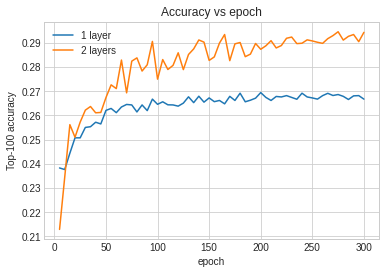

In [14]:
num_validation_runs = len(one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

plt.plot(epochs, one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="1 layer")
plt.plot(epochs, two_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="2 layers")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

Even early on in the training, the larger model has a clear and stable lead over the shallow model, suggesting that adding depth helps the model capture more nuanced relationships in the data.

However, even deeper models are not necessarily better. The following model extends the depth to three layers:

**NOTE: The below cell will take approximately 15~20 minutes to get executed completely.**


In [15]:
# TODO 3a
model = MovielensModel([128, 64, 32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

three_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=0)

accuracy = three_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")


Top-100 accuracy: 0.27.


In fact, we don't see improvement over the shallow model:

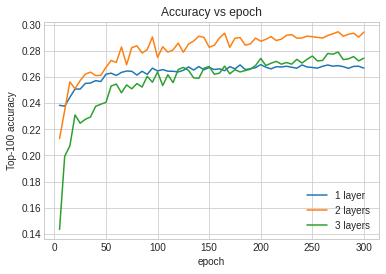

In [16]:
plt.plot(epochs, one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="1 layer")
plt.plot(epochs, two_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="2 layers")
plt.plot(epochs, three_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="3 layers")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

This is a good illustration of the fact that deeper and larger models, while capable of superior performance, often require very careful tuning. For example, throughout this tutorial we used a single, fixed learning rate. Alternative choices may give very different results and are worth exploring. 

With appropriate tuning and sufficient data, the effort put into building larger and deeper models is in many cases well worth it: larger models can lead to substantial improvements in prediction accuracy.



## Next Steps

In this tutorial we expanded our retrieval model with dense layers and activation functions. To see how to create a model that can perform not only retrieval tasks but also rating tasks, take a look at [the multitask tutorial](https://www.tensorflow.org/recommenders/examples/multitask).